In [625]:
import os

os.environ['DDE_BACKEND'] = 'tensorflow'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

import numpy as np
import deepxde as dde

dde.config.set_default_float("float64")
dde.config.set_random_seed(42)
np.random.seed(42)

from deepxde.data import PDE
from deepxde.geometry import TimeDomain
from deepxde.icbc.initial_conditions import IC
from deepxde.icbc import PointSetBC
from deepxde.nn import FNN, PFNN
from deepxde.model import Model
from deepxde.callbacks import VariableValue, EarlyStopping
from deepxde.metrics import mean_squared_error
from scipy.integrate import solve_ivp
from matplotlib import pyplot as plt
import tensorflow
import pandas as pd

from tensorflow.keras.optimizers.schedules import InverseTimeDecay
from custom_models import AdaptativeDataWeightModel

Set the default float type to float64


In [626]:
df = pd.read_csv("../data/FlunetData_United States of America_All Sites_for_28 October 2024 to 20 October 2025.csv")
df = df.sort_values("Week start date (ISO 8601 calendar)")
df = df[df["Surveillance site type"] == "Non-sentinel"]
df[:5]

,Unnamed: 0,Country area or territory,Surveillance site type,Year-week (ISO 8601 calendar),Week start date (ISO 8601 calendar),Specimen tested,Influenza positive,Influenza negative,A (H1N1)pdm09,A (H3),A (H5),A not subtyped,B (Victoria),B (lineage not determined)
0,1,United States of America,Non-sentinel,2024-44,2024-10-28,75257,917,74340,NaN,NaN,NaN,843,NaN,74
1,2,United States of America,Non-sentinel,2024-45,2024-11-04,76717,1172,75545,NaN,NaN,NaN,1088,NaN,84
2,3,United States of America,Non-sentinel,2024-46,2024-11-11,81959,1730,80229,NaN,NaN,NaN,1604,NaN,126
3,4,United States of America,Non-sentinel,2024-47,2024-11-18,86735,2458,84277,NaN,NaN,NaN,2291,NaN,167
4,5,United States of America,Non-sentinel,2024-48,2024-11-25,83810,3309,80501,NaN,NaN,NaN,3122,NaN,187


In [627]:

data_I = df["Influenza positive"].to_numpy()
data_I[:10]

array([  917,  1172,  1730,  2458,  3309,  5064,  9128, 17517, 23900,
       25274])

In [628]:
data_I.shape

(38,)

In [629]:
t0, tf = 0, len(data_I)
gamma = 0.0015
N = 347000000 # population size

data_I_norm = data_I / N
S0, I0, R0 = 1.0, data_I_norm[0], 0.0

beta0 = 0.0001
gamma0 = 0.0001

In [630]:
I0

np.float64(2.6426512968299712e-06)

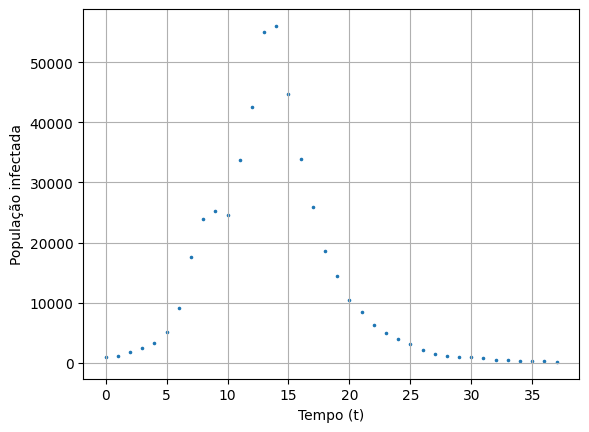

In [631]:
train_t = np.linspace(t0, tf - 1, tf)
plt.scatter(train_t, data_I, s=2.5)
plt.xlabel("Tempo (t)")
plt.ylabel("População infectada")
plt.grid()
plt.show()

In [632]:
timeinterval = TimeDomain(t0, tf)

def sir_residual(t, y):
    S, I, R, beta, gamma = y[:,0:1], y[:,1:2], y[:,2:3], y[:,3:4], y[:,4:5]

    dS_dt = dde.gradients.jacobian(y, t, i=0)
    dI_dt = dde.gradients.jacobian(y, t, i=1)
    dR_dt = dde.gradients.jacobian(y, t, i=2)
    
    return [
        dS_dt + beta * S * I,
        dI_dt - beta * S * I + gamma * I,
        dR_dt - gamma * I
    ]


# Tensorflow has an issue with lambdas...
def is_on_initial(_, on_initial): return on_initial

def S0_val(_): return S0
def I0_val(_): return I0
def R0_val(_): return R0

def beta0_val(_): return beta0
def gamma0_val(_): return gamma0

ic_S = IC(timeinterval, S0_val, is_on_initial, component=0)
ic_I = IC(timeinterval, I0_val, is_on_initial, component=1)
ic_R = IC(timeinterval, R0_val, is_on_initial, component=2)

ic_beta = IC(timeinterval, beta0_val, is_on_initial, component=3)
ic_gamma = IC(timeinterval, gamma0_val, is_on_initial, component=4)

data_t = train_t.reshape(-1, 1)
data_I_bc = PointSetBC(data_t, data_I_norm, component=1)

ics = [
    ic_S, 
    ic_I,
    ic_R, 
    ic_beta,
    ic_gamma
]

data_conds = [
    data_I_bc,
] 

conditions = ics + data_conds

data = PDE(
    timeinterval, 
    sir_residual, 
    conditions,
    num_domain=len(data_I),
    num_boundary=2,
    num_test=len(data_I)//2,
    anchors=data_t
)

n_hidden_layers = 8
hidden_layer_size = 15
topology = [1] + [hidden_layer_size] * n_hidden_layers + [5]
activation = ["tanh"] * n_hidden_layers + ["sigmoid"]
# activation = "tanh"
# activation = "ReLU"
initializer = "Glorot normal"
optimizer = "adam"
lr = 0.002

eq_w = 1
ic_w = 1
data_w = 150

n_equations = 3

# Com L2
# loss_weights = [eq_w] * n_equations + [ic1_w, ic2_w, ic3_w]  + [data_w] * len(data_conds) + [1]

# Sem L2
loss_weights = [eq_w] * n_equations + [ic_w] * len(ics)  + [data_w] * len(data_conds)

net = FNN(
    topology, 
    activation, 
    initializer,
    # regularization=["L2", 1e-5],
    # dropout_rate=0.1,
)

# net = PFNN(
#     topology, 
#     activation, 
#     initializer,
#     # regularization=["L2", 1e-5],
#     # dropout_rate=0,
# )

# def non_zero_hard_constraint(x, y):
#     return tensorflow.nn.relu(y)

# net.apply_output_transform(non_zero_hard_constraint)

# model = AdaptativeDataWeightModel(data, net, n_physics=n_equations + len(ics), n_data=1)
model = Model(data, net)

model.compile(
    optimizer, 
    lr,
    loss_weights=loss_weights
)


Compiling model...
'compile' took 0.006648 s



In [633]:
early_stopping = EarlyStopping(min_delta=1e-12, patience=10000)

adam_iterations = 150000

losshistory, train_state = model.train(
    iterations=adam_iterations, 
    display_every=100,
    callbacks=[
        early_stopping
    ]
)

Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
0         [6.68e-03, 3.48e-03, 1.05e-02, 1.00e+00, 6.98e-12, 0.00e+00, 1.00e-08, 1.00e-08, 1.07e+00]    [2.61e-04, 2.62e-03, 2.46e-03, 1.00e+00, 6.98e-12, 0.00e+00, 1.00e-08, 1.00e-08, 1.07e+00]    []  
100       [7.82e-04, 1.82e-05, 8.20e-05, 1.63e-07, 1.52e-06, 1.92e-05, 8.20e-07, 3.12e-08, 6.15e-05]    [6.72e-04, 2.08e-07, 2.73e-05, 1.63e-07, 1.52e-06, 1.92e-05, 8.20e-07, 3.12e-08, 6.15e-05]    []  
200       [5.17e-04, 1.59e-05, 2.67e-05, 2.41e-07, 1.25e-07, 2.86e-08, 1.04e-08, 8.14e-11, 4.39e-05]    [4.13e-04, 1.48e-07, 8.72e-06, 2.41e-07, 1.25e-07, 2.86e-08, 1.04e-08, 8.14e-11, 4.39e-05]    []  
300       [3.16e-04, 1.31e-05, 1.11e-05, 1.22e-07, 6.47e-08, 2.78e-08, 2.42e-09, 8.77e-10, 3.22e-05]    [2.28e-04, 1.06e-07, 1.93e-06, 1.22e-07, 6.47e-08, 2.78e-0

In [634]:
# model.save("../models/sir-nonoise")
# dde.saveplot(
#     losshistory, 
#     train_state, 
#     issave=True, 
#     isplot=False,
#     output_dir="../losses", 
#     loss_fname=f"loss-sir-nonoise",
#     train_fname=f"train-sir-nonoise",
#     test_fname=f"test-sir-nonoise")

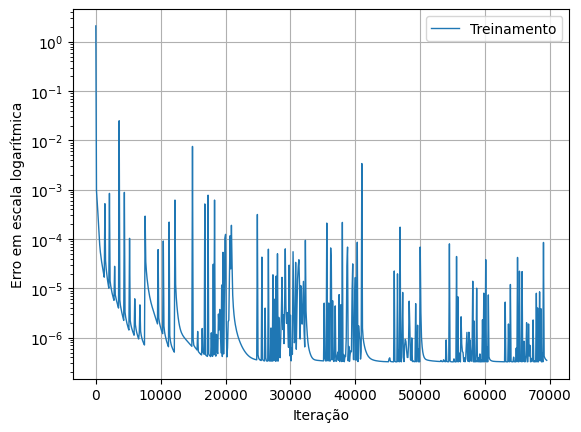

In [635]:
train = np.sum(losshistory.loss_train, axis=1)
plt.semilogy(losshistory.steps, train, "-", label="Treinamento", linewidth=1)
# plt.axhline(y=4.53e-10, color='r', label=r"$Re$ real")
plt.xlabel("Iteração")
plt.ylabel("Erro em escala logarítmica")

plt.legend()
plt.grid()
# plt.savefig(f"../images/sir-loss-nonoise.png")
plt.show()

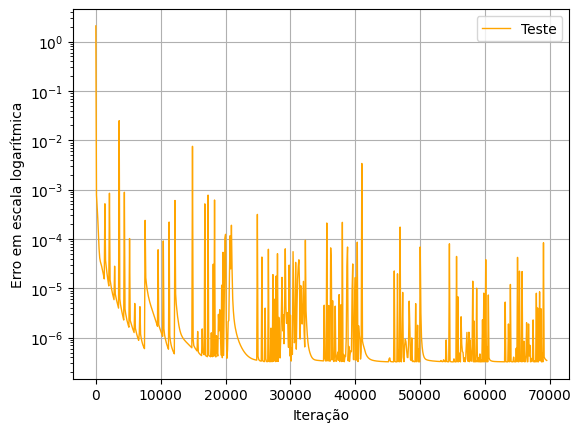

In [636]:
test = np.sum(losshistory.loss_test, axis=1)

plt.semilogy(losshistory.steps, test, "-", label="Teste", color="orange", linewidth=1)

plt.xlabel("Iteração")
plt.ylabel("Erro em escala logarítmica")

plt.legend()
plt.grid()
# plt.savefig(f"../images/sir-loss-nonoise.png")
plt.show()

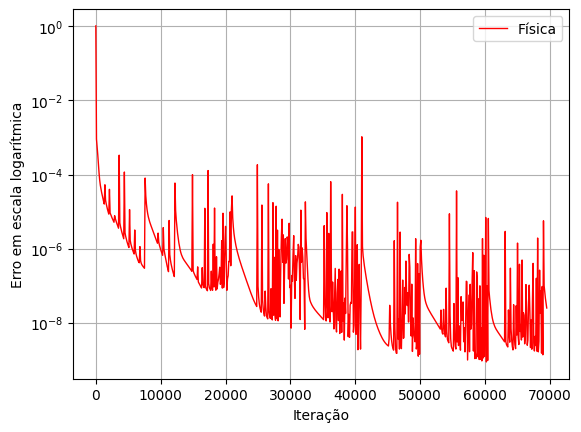

In [637]:
loss_train = np.array(losshistory.loss_train) 

train_phys = np.sum(loss_train[:,:len(ics) + n_equations], axis=1)
plt.semilogy(losshistory.steps, train_phys, "-", label="Física", color="red", linewidth=1)
plt.xlabel("Iteração")
plt.ylabel("Erro em escala logarítmica")
plt.legend()
plt.grid()
plt.show()

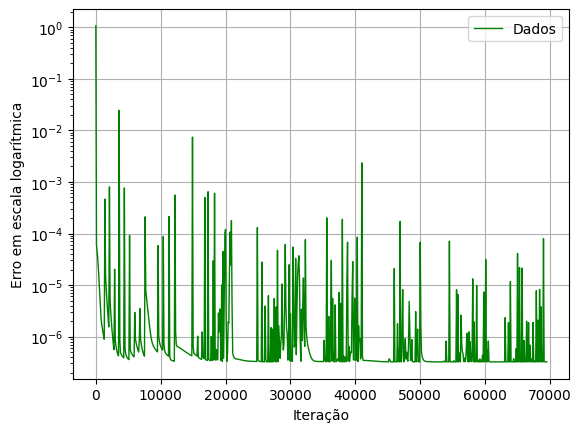

In [638]:
train_data = np.sum(loss_train[:,len(ics) + n_equations:], axis=1)
plt.semilogy(losshistory.steps, train_data, "-", label="Dados", color="green", linewidth=1)
plt.xlabel("Iteração")
plt.ylabel("Erro em escala logarítmica")
plt.legend()
plt.grid()
plt.show()

In [639]:
#plt.semilogy(np.arange(len(model.data_weight_hist)), model.data_weight_hist)
#plt.show()

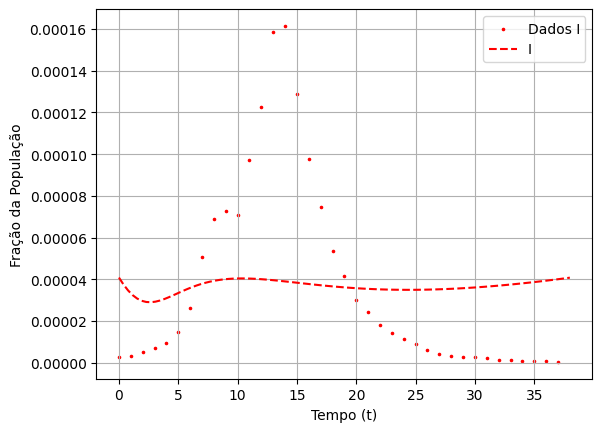

In [640]:
plt.rcParams['text.usetex'] = False
nop_test = 100

test_t = np.linspace(t0, tf, nop_test).reshape(-1, 1)
y_pred = model.predict(test_t)

I_pred = y_pred[:, 1]

plt.scatter(train_t, data_I_norm, label="Dados I", color="red", s=2.5)
plt.plot(test_t, I_pred, label="I", linestyle="--", color="red")

plt.xlabel("Tempo (t)")
plt.ylabel("Fração da População")

plt.legend()
plt.grid()

plt.show()

In [641]:
I_pred

array([4.08514373e-05, 3.75126453e-05, 3.46888013e-05, 3.24411890e-05,
       3.07873942e-05, 2.97060491e-05, 2.91456062e-05, 2.90346963e-05,
       2.92920612e-05, 2.98348015e-05, 3.05844144e-05, 3.14706374e-05,
       3.24334321e-05, 3.34235595e-05, 3.44021982e-05, 3.53399866e-05,
       3.62157785e-05, 3.70153149e-05, 3.77299397e-05, 3.83554309e-05,
       3.88909832e-05, 3.93383481e-05, 3.97011260e-05, 3.99841957e-05,
       4.01932626e-05, 4.03345080e-05, 4.04143213e-05, 4.04390997e-05,
       4.04151022e-05, 4.03483466e-05, 4.02445399e-05, 4.01090341e-05,
       3.99468023e-05, 3.97624291e-05, 3.95601124e-05, 3.93436723e-05,
       3.91165662e-05, 3.88819070e-05, 3.86424839e-05, 3.84007840e-05,
       3.81590148e-05, 3.79191261e-05, 3.76828317e-05, 3.74516297e-05,
       3.72268223e-05, 3.70095343e-05, 3.68007303e-05, 3.66012306e-05,
       3.64117260e-05, 3.62327914e-05, 3.60648986e-05, 3.59084270e-05,
       3.57636745e-05, 3.56308668e-05, 3.55101659e-05, 3.54016776e-05,
      

[]

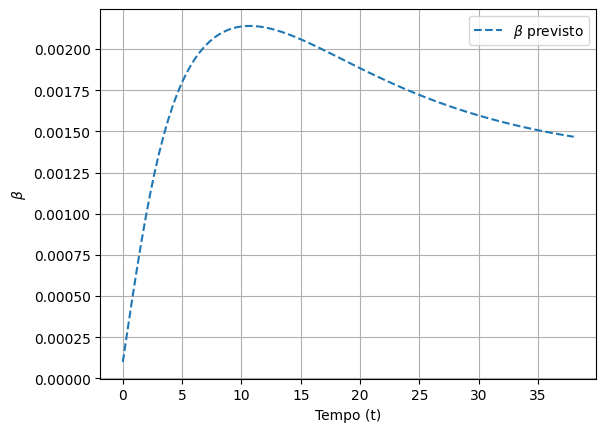

In [642]:
beta_pred = y_pred[:, 3]
plt.plot(test_t, beta_pred, label=r"$\beta$ previsto", linestyle="--")
plt.xlabel("Tempo (t)")
plt.ylabel(r"$\beta$")
plt.legend()
plt.grid()
plt.plot()

[]

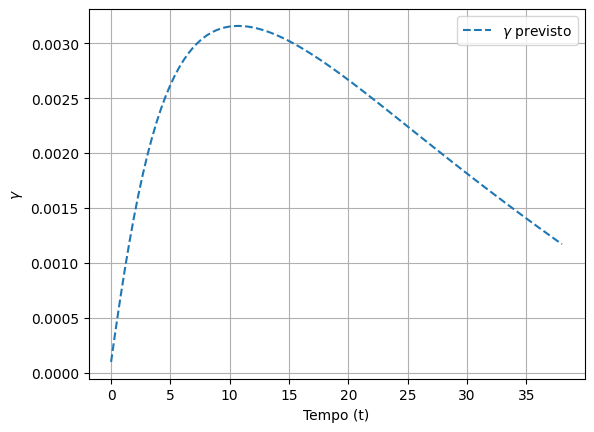

In [643]:
beta_pred = y_pred[:, 4]
plt.plot(test_t, beta_pred, label=r"$\gamma$ previsto", linestyle="--")
plt.xlabel("Tempo (t)")
plt.ylabel(r"$\gamma$")
plt.legend()
plt.grid()
plt.plot()

In [644]:
beta_pred

array([9.99971161e-05, 3.92367297e-04, 6.72004016e-04, 9.36161845e-04,
       1.18296688e-03, 1.41137335e-03, 1.62104590e-03, 1.81220657e-03,
       1.98547902e-03, 2.14175096e-03, 2.28206377e-03, 2.40753063e-03,
       2.51927929e-03, 2.61841428e-03, 2.70599337e-03, 2.78301385e-03,
       2.85040550e-03, 2.90902796e-03, 2.95967092e-03, 3.00305615e-03,
       3.03984067e-03, 3.07062065e-03, 3.09593561e-03, 3.11627288e-03,
       3.13207203e-03, 3.14372914e-03, 3.15160098e-03, 3.15600892e-03,
       3.15724259e-03, 3.15556325e-03, 3.15120686e-03, 3.14438695e-03,
       3.13529712e-03, 3.12411332e-03, 3.11099591e-03, 3.09609148e-03,
       3.07953439e-03, 3.06144823e-03, 3.04194702e-03, 3.02113632e-03,
       2.99911410e-03, 2.97597158e-03, 2.95179393e-03, 2.92666083e-03,
       2.90064701e-03, 2.87382268e-03, 2.84625387e-03, 2.81800279e-03,
       2.78912808e-03, 2.75968504e-03, 2.72972583e-03, 2.69929965e-03,
       2.66845291e-03, 2.63722933e-03, 2.60567009e-03, 2.57381393e-03,
      

[]

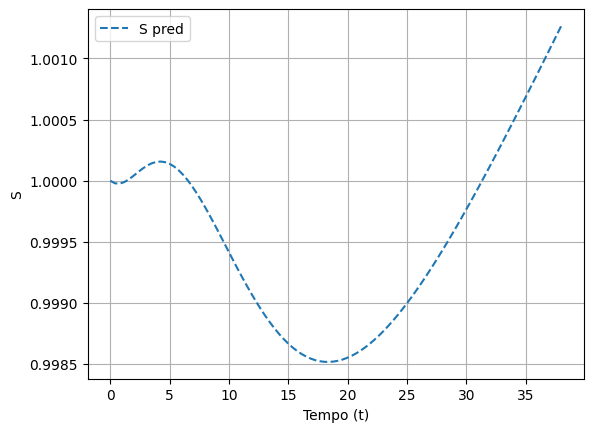

In [645]:
S_pred = y_pred[:, 0]
plt.plot(test_t, S_pred, label=r"S pred", linestyle="--")
plt.xlabel("Tempo (t)")
plt.ylabel(r"S")
plt.legend()
plt.grid()
plt.plot()

In [646]:
S_pred

array([0.99999988, 0.99997858, 0.99997571, 0.99998732, 1.00000921,
       1.00003718, 1.00006735, 1.00009639, 1.00012159, 1.00014088,
       1.00015284, 1.00015657, 1.00015164, 1.00013798, 1.00011578,
       1.00008546, 1.0000476 , 1.00000287, 0.999952  , 0.99989579,
       0.99983503, 0.99977052, 0.99970305, 0.99963336, 0.99956218,
       0.9994902 , 0.99941804, 0.99934631, 0.99927554, 0.99920623,
       0.99913882, 0.99907372, 0.99901128, 0.9989518 , 0.99889556,
       0.99884278, 0.99879365, 0.99874832, 0.99870692, 0.99866954,
       0.99863625, 0.99860707, 0.99858204, 0.99856114, 0.99854436,
       0.99853164, 0.99852294, 0.99851819, 0.99851731, 0.99852021,
       0.99852679, 0.99853696, 0.9985506 , 0.9985676 , 0.99858785,
       0.99861122, 0.9986376 , 0.99866687, 0.9986989 , 0.99873358,
       0.99877079, 0.99881042, 0.99885234, 0.99889646, 0.99894265,
       0.99899082, 0.99904086, 0.99909267, 0.99914616, 0.99920123,
       0.9992578 , 0.99931578, 0.99937509, 0.99943565, 0.99949

[]

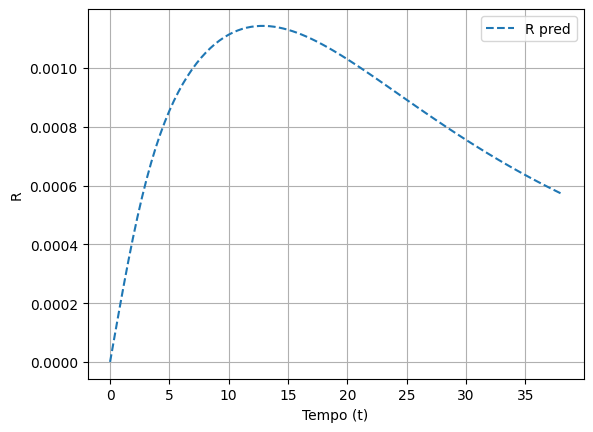

In [647]:
R_pred = y_pred[:, 2]
plt.plot(test_t, R_pred, label=r"R pred", linestyle="--")
plt.xlabel("Tempo (t)")
plt.ylabel(r"R")
plt.legend()
plt.grid()
plt.plot()

In [648]:
R_pred

array([1.99050717e-07, 8.82492347e-05, 1.75497093e-04, 2.60576798e-04,
       3.42286890e-04, 4.19671553e-04, 4.92061906e-04, 5.59077980e-04,
       6.20599622e-04, 6.76718030e-04, 7.27679478e-04, 7.73830324e-04,
       8.15569195e-04, 8.53309190e-04, 8.87450676e-04, 9.18363738e-04,
       9.46378595e-04, 9.71782092e-04, 9.94818407e-04, 1.01569245e-03,
       1.03457473e-03, 1.05160676e-03, 1.06690645e-03, 1.08057307e-03,
       1.09269160e-03, 1.10333637e-03, 1.11257400e-03, 1.12046575e-03,
       1.12706924e-03, 1.13243971e-03, 1.13663095e-03, 1.13969581e-03,
       1.14168660e-03, 1.14265520e-03, 1.14265316e-03, 1.14173157e-03,
       1.13994101e-03, 1.13733138e-03, 1.13395180e-03, 1.12985036e-03,
       1.12507407e-03, 1.11966867e-03, 1.11367852e-03, 1.10714652e-03,
       1.10011401e-03, 1.09262071e-03, 1.08470471e-03, 1.07640239e-03,
       1.06774844e-03, 1.05877588e-03, 1.04951603e-03, 1.03999856e-03,
       1.03025152e-03, 1.02030138e-03, 1.01017307e-03, 9.99890018e-04,
      